In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

np.random.seed(0)
random.seed(0)

import sys
sys.path.append("..")
import utils as ut

In [2]:
def preprocess_data(path_param, pat, pam50_genes):
    labels_0 = np.genfromtxt(path_param, delimiter='\t', usecols=0, dtype=str)[1:]
    labels_0 = ut.check_gene_names(labels_0)
    # intersection labels (all genes) & pam50_genes
    labels = list(set(labels_0).intersection(pam50_genes)) # 50 genes
    #labels_without_pam = [x for x in labels_0 if x not in labels] # uncomment if you want to add random genes
    #labels_random = random.sample(labels_without_pam, 50) 
    #labels += labels_random
    patients = list(np.genfromtxt(path_param, delimiter='\t', dtype=str)[0, 1:])
    for i in range(len(patients)):
        patients[i] = patients[i][:-3]
    l = ut.get_column_indices(patients, pat) # 541 indices
    l = [x+1 for x in l] # since 0 index in raw_data is gene_id, we need to +1 to every index
    raw_data = np.genfromtxt(path_param, usecols = l)
    raw_data = np.delete(raw_data, 0, axis=0)
    data = {label: row for label, row in zip(labels, raw_data)}
    return data

## Molecular subtypes

In [3]:
path_subtypes = "../multi_omic/BRCA_molecularCBIO_patient_strat.txt"
patient_subtype = {}
with open(path_subtypes, "r") as f:
    for line in f:
        (key, val) = line.split()
        patient_subtype[key] = val

In [4]:
for key, value in list(patient_subtype.items()):
    if value=="nan":
        patient_subtype.pop(key)

In [5]:
len(patient_subtype)

981

There are 981 patients.

In [6]:
subtypes = np.unique(list(patient_subtype.values()))
subtypes

array(['BRCA_Basal', 'BRCA_Her2', 'BRCA_LumA', 'BRCA_LumB', 'BRCA_Normal'],
      dtype='<U11')

In [7]:
len(subtypes)

5

There are 5 subtypes of BIC.

## BIC

In [8]:
path = "../multi_omic/BIC/BIC_gene_subset.txt"
patients = np.genfromtxt(path, delimiter='\t', dtype=str)[0, 1:]

In [9]:
len(patients)

685

In [10]:
for i in range(len(patients)):
    patients[i] = patients[i][:-3]

In [11]:
for key in list(patient_subtype.keys()):
    x = key.replace('-', '.')
    patient_subtype[x] = patient_subtype.pop(key)

In [12]:
common_patients = list(set(patients).intersection(patient_subtype)) 

In [13]:
len(common_patients)

541

## PAM50 and filtering patients

In [14]:
pam50 = "../multi_omic/pam50_annotation.txt"
pam50_genename = {}
with open(pam50, "r") as f:
    for line in f:
        (pcrID, UniGene, EntrezGene, GeneName, InProliferation) = line.split()
        pam50_genename[pcrID] = GeneName
pam50_genes = list(pam50_genename.values())[1:]

In [15]:
patient_subtype_filtered = { your_key: patient_subtype[your_key] for your_key in common_patients }

In [16]:
basal, her2, luma, lumb, normal = 0, 0, 0, 0, 0
for (key, value) in patient_subtype_filtered.items():
    if value == 'BRCA_Basal':
        basal += 1
    elif value == 'BRCA_LumA':
        luma += 1
    elif value == 'BRCA_LumB':
        lumb += 1
    elif value == 'BRCA_Her2':
        her2 += 1
    elif value == 'BRCA_Normal':
        normal += 1

In [17]:
basal, her2, luma, lumb, normal # most of the patients have LumA subtype

(92, 36, 277, 109, 27)

We should reorder patients by columns in the following order: BRCA_LumA, BRCA_LumB, BRCA_Basal, BRCA_Her2, and BRCA_Normal.

In [18]:
order = ["BRCA_LumA", "BRCA_LumB", "BRCA_Basal", "BRCA_Her2", "BRCA_Normal"]
patient_subtype_sorted = sorted(patient_subtype_filtered.items(), key=lambda x: order.index(x[1])) 

In [19]:
pat = [i[0] for i in patient_subtype_sorted] # list of patients 

In [20]:
len(pat)

541

In [21]:
data = preprocess_data(path, pat, pam50_genes)

In [22]:
pam50_data = []
for key in data.keys():
    pam50_data.append(data[key])
pam50_data = np.array(pam50_data)
pam50_data.shape

(50, 541)

In [23]:
pam50_data, row_perm = ut.return_permData_rowPerm(pam50_data)

# polo by subtypes separately
luma_data, a_perm = ut.return_permData_colPerm(pam50_data[:, 0:277]) # 277
lumb_data, b_perm = ut.return_permData_colPerm(pam50_data[:, 277:386]) # 109
basal_data, c_perm = ut.return_permData_colPerm(pam50_data[:, 386:478]) # 92
her2_data, d_perm = ut.return_permData_colPerm(pam50_data[:, 478:514]) # 36
normal_data, e_perm = ut.return_permData_colPerm(pam50_data[:, 514:541]) # 27

In [24]:
pam50_data = np.concatenate((luma_data, lumb_data, basal_data, her2_data, normal_data), axis=1)
np.savetxt("../multi_omic/bic_subtypes_pam.csv", pam50_data, delimiter=",")

In [25]:
pam50_data.shape

(50, 541)

## Visualization

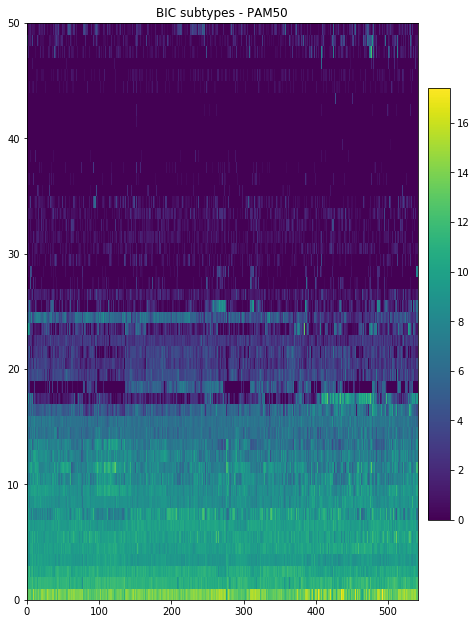

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 10))
a = ax.pcolor(pam50_data) 
ax.set_title("BIC subtypes - PAM50")
fig.tight_layout()
fig.subplots_adjust(top=0.84)
cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.6])
fig.colorbar(a, cax=cbar_ax)
fig.savefig("../multi_omic/bic_subtypes_pam50.png", bbox_inches = 'tight', dpi=300);
plt.show()

In [27]:
# # every 2nd column
# pam50_data = pam50_data[:, 1::2]
# np.savetxt("../multi_omic/bic_subtypes_pam_small.csv", pam50_data, delimiter=",")

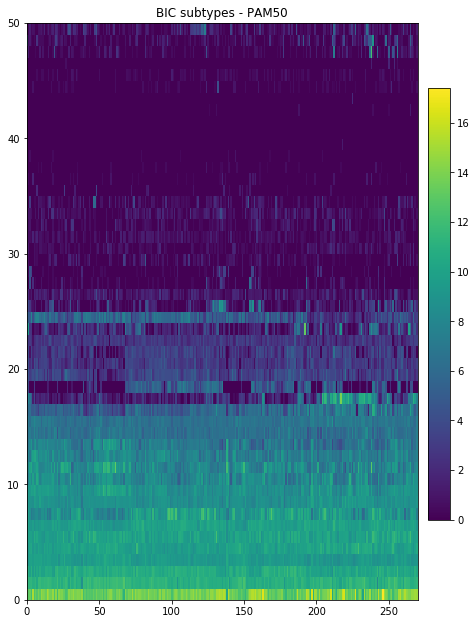

In [28]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 10))
# a = ax.pcolor(pam50_data) 
# ax.set_title("BIC subtypes - PAM50")
# fig.tight_layout()
# fig.subplots_adjust(top=0.84)
# cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.6])
# fig.colorbar(a, cax=cbar_ax)
# fig.savefig("../multi_omic/bic_subtypes_pam50_small.png", bbox_inches = 'tight', dpi=300);
# plt.show()